# 설정, 임포트, 파일 업로드

In [ ]:
import pandas as pd
import numpy as np
import sys
import traceback
import re  # 정규표현식(Regex) 모듈
import json # 스케일러 정보 공유 (분리 시 필요)

# --- 1. 설정 및 파일 경로 ---
np.random.seed(42) # 랜덤 결과를 동일하게 고정

# 입력 파일
file_renttherunway = "renttherunway_final_data.csv"
file_modcloth = "modcloth_final_data.csv"
file_articles = "articles.csv" # H&M 아이템 이름
file_hm_labeled = "hm_articles_rentfor_top3_11cats.csv" # H&M 아이템 라벨
file_ratings_filled = "renttherunway_filled.csv" # 결측치 평점

# 최종 출력 파일
out_train_file = "renttherunway_processed_final.csv"
out_test_file = "modcloth_processed_final.csv"
# out_scaler_info = "scaler_info.json" # (한번에 돌릴 때는 이 파일 필요 없음)

# [신규] 제외할 카테고리 목록
excluded_rent_for_categories = ['photoshoot', 'formal_affair']

# Min-Max 스케일링(0-10점)을 위한 전역 변수 (3번 셀에서 채워짐)
min_size = 0
max_size = 0

# H&M DB 전역 변수 (2번 셀에서 채워짐)
hm_dresses_db_indexed = None
hm_codes_100pct = None
hm_dresses_db_100pct = None # (Test 60% 샘플링을 위해 추가)

print("--- [셀 1/4] 설정 및 임포트 완료 ---")
print(f"제외할 RentFor 카테고리: {', '.join(excluded_rent_for_categories)}")

--- [셀 1/4] 설정 및 임포트 완료 ---
제외할 RentFor 카테고리: photoshoot, formal_affair


# 공통 사용 함수 및 H&M DB 준비

In [ ]:
# --- 0. 보조 함수 정의 ---

def convert_height_to_cm(s):
    """ "5' 8"" 또는 "5ft 6in" 같은 문자열을 cm(float)로 변환 """
    if pd.isna(s): return np.nan
    s = str(s).strip().replace('"', '').replace('in', '')
    feet, inches = 0, 0
    try:
        if "'" in s:
            parts = s.split("'")
            feet = int(parts[0].strip())
            if len(parts) > 1 and parts[1].strip(): inches = int(parts[1].strip())
        elif "ft" in s:
            parts = s.split("ft")
            feet = int(parts[0].strip())
            if len(parts) > 1 and parts[1].strip(): inches = int(parts[1].strip())
        else: return np.nan
        total_inches = (feet * 12) + inches
        return total_inches * 2.54
    except ValueError: return np.nan

def convert_weight_to_kg(s):
    """ "130lbs" 같은 문자열을 kg(float)로 변환 """
    if pd.isna(s): return np.nan
    s_cleaned = str(s).lower().replace('lbs', '').strip()
    try:
        weight_lbs = float(s_cleaned)
        return weight_lbs * 0.453592
    except ValueError: return np.nan

def split_bust_size(s):
    """ "34d", "34d+", "32dd/e" 같은 문자열을 ("34", "d") 또는 ("34", "dd/e")로 분리 """
    if pd.isna(s): return pd.Series({"bra size": "unknown", "cup size": "unknown"})
    s = str(s).strip()
    match = re.match(r"^(\d+)([a-z/\\+]+.*)$", s, re.IGNORECASE)
    if match:
        bra_size = match.group(1)
        cup_size = match.group(2).lower().replace('+', '').strip()
        return pd.Series({"bra size": bra_size, "cup size": cup_size})
    else:
        return pd.Series({"bra size": "unknown", "cup size": "unknown"})

def convert_size_to_numeric(s):
    """ "8", "51" 등 숫자로 시작하는 문자열에서 숫자(float)만 추출 """
    if pd.isna(s): return np.nan
    s_clean = str(s).strip().lower()
    try:
        match = re.search(r"^([\d\.]+)", s_clean)
        if match: return float(match.group(1))
        else: return np.nan
    except ValueError: return np.nan

# --- 메인 코드 시작 ---
# (셀 3, 4에서 오류 발생 시 잡기 위해 try...except로 감싸기 시작)
try:
    # --- 2. H&M 드레스 DB 준비 (100% 마스터 목록) ---
    print("\n--- [셀 2/4] 공통 함수 정의 및 H&M DB 준비 시작 ---")

    # 2a. articles.csv 로드
    df_articles = pd.read_csv(file_articles, encoding='latin-1', dtype={'product_code': str})
    df_articles['product_code'] = df_articles['product_code'].str.zfill(10)
    df_dress_data = df_articles[df_articles['product_type_name'] == 'Dress'][
        ['product_code', 'prod_name']
    ].drop_duplicates(subset=['product_code'], keep='first')

    if df_dress_data.empty: sys.exit("[오류] 'articles.csv'에서 'Dress' 타입을 찾을 수 없습니다.")
    print(f"  'articles.csv'에서 'Dress' 타입 고유 product_code {len(df_dress_data):,}개와 prod_name 매핑 확인.")

    # 2b. 라벨링된 H&M 파일 로드
    df_hm_labeled = pd.read_csv(file_hm_labeled, dtype={'product_code': str})
    df_hm_labeled['product_code'] = df_hm_labeled['product_code'].str.zfill(10)
    df_hm_labeled_unique = df_hm_labeled.drop_duplicates(subset=['product_code'], keep='first')

    # 2c. H&M 마스터 DB 생성 (전역 변수로 할당)
    hm_dresses_db_100pct = pd.merge(
        df_dress_data, df_hm_labeled_unique, on='product_code', how='inner'
    )
    if hm_dresses_db_100pct.empty: sys.exit("[오류] 'Dress' 타입의 이름과 라벨링 정보가 일치하는 H&M 데이터가 없습니다.")

    # 2d. 'rent_for' 유사도가 모두 0인 product_code 제거
    score_cols = ['rf11_s1', 'rf11_s2', 'rf11_s3']
    hm_dresses_db_100pct[score_cols] = hm_dresses_db_100pct[score_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    mask_has_score = hm_dresses_db_100pct[score_cols].sum(axis=1) > 0
    hm_dresses_db_100pct = hm_dresses_db_100pct[mask_has_score]

    print(f"  H&M 마스터 DB (유사도 0점 드레스 제거 후): {len(hm_dresses_db_100pct):,}개")
    if hm_dresses_db_100pct.empty: sys.exit("[오류] 유효한 'rent_for' 유사도 점수를 가진 H&M 드레스가 없습니다.")

    # 2e. DB 인덱싱 (전역 변수로 할당)
    hm_dresses_db_indexed = hm_dresses_db_100pct.set_index('product_code')
    hm_codes_100pct = hm_dresses_db_100pct['product_code'].values

    print("--- [셀 2/4] H&M DB 준비 완료 ---")

except Exception as e:
    print(f"--- [셀 2/4] 처리 중 예기치 않은 오류 발생 ---")
    print(f"오류: {e}")
    traceback.print_exc()


--- [셀 2/4] 공통 함수 정의 및 H&M DB 준비 시작 ---
  'articles.csv'에서 'Dress' 타입 고유 product_code 5,551개와 prod_name 매핑 확인.
  H&M 마스터 DB (유사도 0점 드레스 제거 후): 3,766개
--- [셀 2/4] H&M DB 준비 완료 ---


# 훈련 데이터 (renttherunway) 처리



In [ ]:
# (try...except 블록은 셀 2에서 시작되어 셀 4에서 끝납니다)
try:
    # --- 3. 훈련 데이터 (Train Set) 처리 (RentTheRunway) ---
    print(f"\n--- [셀 3/4] 훈련 데이터 ({file_renttherunway}) 처리 시작 ---")

    # 3a. 훈련 데이터 원본 로드
    df_train_raw = pd.read_csv(file_renttherunway)
    print(f"  원본 {len(df_train_raw):,}건 로드.")

    # 3b. 'rating' 값 업데이트
    try:
        df_filled = pd.read_csv(file_ratings_filled)
        df_filled_ratings = df_filled[['user_id', 'item_id', 'rating']].rename(columns={'rating': 'filled_rating'})
        df_train_raw = pd.merge(
            df_train_raw, df_filled_ratings, on=['user_id', 'item_id'], how='left'
        )
        mask = df_train_raw['filled_rating'].notna()
        df_train_raw.loc[mask, 'rating'] = df_train_raw.loc[mask, 'filled_rating']
        df_train_raw = df_train_raw.drop(columns=['filled_rating'])
        print(f"  Train: 'rating' 업데이트 완료.")
    except FileNotFoundError:
        print(f"  [경고] '{file_ratings_filled}' 파일을 찾을 수 없습니다. Rating 채우기를 건너뜁니다.")

    # 3c. 'category' == 'dress' 필터링
    df_train = df_train_raw[df_train_raw['category'] == 'dress'].copy()
    print(f"  'category'가 'dress'인 훈련 데이터 {len(df_train):,}건 필터링 완료.")

    # 3d. 훈련 데이터 단위 통일
    print("  Train: 단위 통일 시작...")

    if 'rating' in df_train.columns:
        df_train['rating'] = pd.to_numeric(df_train['rating'], errors='coerce')

    df_train['height'] = df_train['height'].apply(convert_height_to_cm)
    df_train = df_train.dropna(subset=['height'])
    df_train = df_train.rename(columns={'height': 'height_cm'})

    if 'weight' in df_train.columns:
        df_train['weight'] = df_train['weight'].apply(convert_weight_to_kg)
        df_train = df_train.rename(columns={'weight': 'weight_kg'})

    bust_split_train = df_train['bust size'].apply(split_bust_size)
    df_train[bust_split_train.columns] = bust_split_train
    df_train = df_train.drop(columns=['bust size'])

    # 3d-5. Clothing Size (0-10 Min-Max 스케일링)
    if 'size' in df_train.columns:
        df_train['size_numeric'] = df_train['size'].apply(convert_size_to_numeric)
        df_train = df_train.dropna(subset=['size_numeric'])

        # [중요] 전역 변수 min_size, max_size에 값 할당
        min_size = df_train['size_numeric'].min()
        max_size = df_train['size_numeric'].max()
        print(f"  Train: Size 스케일러 기준값 설정 (Min={min_size}, Max={max_size}).")

        if (max_size - min_size) == 0:
            df_train['size_scaled_0_to_10'] = 5.0
        else:
            df_train['size_scaled_0_to_10'] = 10 * (df_train['size_numeric'] - min_size) / (max_size - min_size)

        df_train = df_train.drop(columns=['size', 'size_numeric'])
        print(f"  Train: 'size' -> 'size_scaled_0_to_10' 정규화 완료. (남은 {len(df_train):,}건)")
    else:
        sys.exit("오류: Train 데이터에 'size' 컬럼이 없어 스케일링 기준을 설정할 수 없습니다.")

    # 3e. 컬럼명 통일
    df_train = df_train.rename(columns={'item_id': 'product_code'})

    # 3f. product_code 랜덤 할당 (셀 2에서 만든 hm_codes_100pct 사용)
    assigned_codes_train = np.random.choice(hm_codes_100pct, size=len(df_train))
    df_train['product_code'] = assigned_codes_train

    # 3g. 할당된 정보 조회 (셀 2에서 만든 hm_dresses_db_indexed 사용)
    assigned_data_train = hm_dresses_db_indexed.loc[assigned_codes_train]

    # 3h. 'prod_name' 컬럼 추가
    df_train['prod_name'] = assigned_data_train['prod_name'].values

    # 3i. 'rented for' 값을 (유사도 > 0 인) Top-3 라벨 중 하나로 교체
    rf_options_train = assigned_data_train[['rf11_top1', 'rf11_top2', 'rf11_top3']].to_numpy()
    rf_scores_train = assigned_data_train[['rf11_s1', 'rf11_s2', 'rf11_s3']].to_numpy()

    assigned_rent_for_train = []
    for i in range(len(df_train)):
        options = rf_options_train[i]
        scores = rf_scores_train[i]
        valid_options = [opt for opt, score in zip(options, scores) if score > 0]
        assigned_rent_for_train.append(np.random.choice(valid_options))
    df_train['rented for'] = assigned_rent_for_train

    # 3j. 컬럼 순서 재배치
    all_cols_train = df_train.columns.tolist()
    other_cols_train = [col for col in all_cols_train if col not in ['product_code', 'prod_name']]
    final_cols_train = ['product_code', 'prod_name'] + other_cols_train
    df_train = df_train[final_cols_train]

    # 3j_2. 'photoshoot', 'formal_affair' 카테고리 제외
    initial_count_train = len(df_train)
    df_train = df_train[~df_train['rented for'].isin(excluded_rent_for_categories)]
    removed_count = initial_count_train - len(df_train)
    print(f"  Train: 'rented for' 제외. {removed_count:,}건 제거됨. (남은 {len(df_train):,}건)")

    # 3k. 파일 저장
    df_train.to_csv(out_train_file, index=False, encoding='utf-8-sig')
    print(f"훈련 데이터 처리 완료 -> {out_train_file}")

    print("--- [셀 3/4] 훈련 데이터 처리 완료 ---")

except Exception as e:
    print(f"--- [셀 3/4] 처리 중 예기치 않은 오류 발생 ---")
    print(f"오류: {e}")
    traceback.print_exc()


--- [셀 3/4] 훈련 데이터 (renttherunway_final_data.csv) 처리 시작 ---
  원본 192,544건 로드.
  Train: 'rating' 업데이트 완료.
  'category'가 'dress'인 훈련 데이터 93,236건 필터링 완료.
  Train: 단위 통일 시작...
  Train: Size 스케일러 기준값 설정 (Min=0.0, Max=57.0).
  Train: 'size' -> 'size_scaled_0_to_10' 정규화 완료. (남은 92,921건)
  Train: 'rented for' 제외. 42건 제거됨. (남은 92,879건)
훈련 데이터 처리 완료 -> renttherunway_processed_final.csv
--- [셀 3/4] 훈련 데이터 처리 완료 ---


# test data (modcloth) 전처리

In [ ]:
# (try...except 블록은 셀 2에서 시작되어 여기서 끝납니다)
try:
    # --- 4. 테스트 데이터 (Test Set) 처리 (ModCloth) ---
    print(f"\n--- [셀 4/4] 테스트 데이터 ({file_modcloth}) 처리 시작 ---")

    # 4a. 로드 및 'dresses' 카테고리 필터링
    df_test_raw = pd.read_csv(file_modcloth)
    df_test = df_test_raw[df_test_raw['category'] == 'dresses'].copy()
    print(f"  원본 {len(df_test_raw):,}건 -> 'dresses' {len(df_test):,}건 필터링.")

    # 4b. 테스트 데이터 단위 통일
    print("  Test: 단위 통일 시작...")

    # 4b-1. Rating (ModCloth 'quality' 0-5 -> 'rating' 0-10으로 보정)
    if 'quality' in df_test.columns:
        df_test['quality'] = pd.to_numeric(df_test['quality'], errors='coerce') * 2.0
        df_test['quality'] = df_test['quality'].clip(0, 10)
        df_test = df_test.rename(columns={'quality': 'rating'})
        print("    Test: 'quality' (0-5) -> 'rating' (0-10) 스케일 보정 완료.")
    elif 'rating' in df_test.columns:
         df_test['rating'] = pd.to_numeric(df_test['rating'], errors='coerce') * 2.0
         df_test['rating'] = df_test['rating'].clip(0, 10)
         print("    Test: 'rating' (0-5) -> 'rating' (0-10) 스케일 보정 완료.")
    else:
        print("    Test: 'quality' 또는 'rating' 컬럼을 찾을 수 없어 표준화를 건너뜁니다.")

    # 4b-2. Height (cm로 변환, 결측치 제거)
    df_test['height'] = df_test['height'].apply(convert_height_to_cm)
    df_test = df_test.dropna(subset=['height'])
    df_test = df_test.rename(columns={'height': 'height_cm'})
    print(f"    Test: Height -> cm 변환. (남은 {len(df_test):,}건)")

    # 4b-3. Weight (lbs -> kg)
    if 'weight' in df_test.columns:
        df_test['weight'] = df_test['weight'].apply(convert_weight_to_kg)
        df_test = df_test.rename(columns={'weight': 'weight_kg'})
        print("    Test: Weight -> kg 변환.")
    else:
        print("    Test: 'weight' 컬럼을 찾을 수 없어 표준화를 건너뜁니다.")

    # 4b-4. Bust Size (결측치 'unknown' 처리)
    df_test['bra size'] = df_test['bra size'].astype(float).astype('Int64').astype(str).replace('<NA>', 'unknown')
    df_test['cup size'] = df_test['cup size'].fillna('unknown').apply(lambda x: str(x).lower().replace('+', '').strip())
    print("    Test: 'bra size', 'cup size' 정제/결측치 처리 완료.")

    # 4b-5. Clothing Size (0-10 정규화 - *Train 기준* 적용)
    # [중요] 셀 3에서 계산된 전역 변수 min_size, max_size를 사용합니다.
    if 'size' in df_test.columns:
        df_test['size_numeric'] = df_test['size'].apply(convert_size_to_numeric)
        df_test = df_test.dropna(subset=['size_numeric'])

        if (max_size - min_size) == 0:
            df_test['size_scaled_0_to_10'] = 5.0
        else:
            df_test['size_scaled_0_to_10'] = 10 * (df_test['size_numeric'] - min_size) / (max_size - min_size)

        df_test['size_scaled_0_to_10'] = df_test['size_scaled_0_to_10'].clip(0, 10)
        df_test = df_test.drop(columns=['size', 'size_numeric'])
        print(f"    Test: 'size' -> 'size_scaled_0_to_10' (Train 기준) 정규화 완료. (남은 {len(df_test):,}건)")
    else:
        print("    Test: 'size' 컬럼을 찾을 수 없어 표준화를 건너뜁니다.")

    # 4c. 컬럼명 통일
    df_test = df_test.rename(columns={'item_id': 'product_code'})

    # 4d. 60% H&M DB (샘플) 생성 (셀 2에서 만든 hm_dresses_db_100pct 사용)
    hm_dresses_db_60pct = hm_dresses_db_100pct.sample(frac=0.6, random_state=42)
    hm_codes_60pct = hm_dresses_db_60pct['product_code'].values
    print(f"  H&M 드레스 60% 샘플 목록 생성: {len(hm_codes_60pct):,}개")

    # 4e. product_code 랜덤 할당
    assigned_codes_test = np.random.choice(hm_codes_60pct, size=len(df_test))
    df_test['product_code'] = assigned_codes_test

    # 4f. 할당된 정보 조회 (셀 2에서 만든 hm_dresses_db_indexed 사용)
    assigned_data_test = hm_dresses_db_indexed.loc[assigned_codes_test]

    # 4g. 'prod_name' 컬럼 신규 생성
    df_test['prod_name'] = assigned_data_test['prod_name'].values

    # 4h. 'rented for' 컬럼 신규 생성
    rf_options_test = assigned_data_test[['rf11_top1', 'rf11_top2', 'rf11_top3']].to_numpy()
    rf_scores_test = assigned_data_test[['rf11_s1', 'rf11_s2', 'rf11_s3']].to_numpy()

    assigned_rent_for_test = []
    for i in range(len(df_test)):
        options = rf_options_test[i]
        scores = rf_scores_test[i]
        valid_options = [opt for opt, score in zip(options, scores) if score > 0]
        assigned_rent_for_test.append(np.random.choice(valid_options))
    df_test['rented for'] = assigned_rent_for_test

    # 4i. 컬럼 순서 재배치
    all_cols_test = df_test.columns.tolist()
    other_cols_test = [col for col in all_cols_test if col not in ['product_code', 'prod_name']]
    final_cols_test = ['product_code', 'prod_name'] + other_cols_test
    df_test = df_test[final_cols_test]

    # 4i_2. 'photoshoot', 'formal_affair' 카테고리 제외
    initial_count_test = len(df_test)
    df_test = df_test[~df_test['rented for'].isin(excluded_rent_for_categories)]
    removed_count = initial_count_test - len(df_test)
    print(f"  Test: 'rented for' 제외. {removed_count:,}건 제거됨. (남은 {len(df_test):,}건)")

    # 4j. 파일 저장
    df_test.to_csv(out_test_file, index=False, encoding='utf-8-sig')
    print(f"테스트 데이터 처리 완료 -> {out_test_file}")

    print("\n--- [셀 4/4] 모든 작업 완료 ---")

# --- 최종 오류 핸들링 ---
# (셀 2, 3, 4에서 발생한 모든 오류를 여기서 잡습니다)
except FileNotFoundError as e:
    print(f"[파일 로드 오류] {e}.")
    print("필요한 파일 5개(renttherunway, modcloth, articles, hm_articles..., renttherunway_filled)가 스크립트와 같은 폴더에 있는지 확인하세요.")
except KeyError as e:
    print(f"[KeyError] {e}.")
    print("원본 CSV 파일에 'item_id', 'category', 'bust size', 'height', 'weight', 'rating'/'quality', 'size' 등의 필수 컬럼명이 정확히 존재하는지 확인하세요.")
except Exception as e:
    print(f"처리 중 예기치 않은 오류 발생: {e}")
    traceback.print_exc()


--- [셀 4/4] 테스트 데이터 (modcloth_final_data.csv) 처리 시작 ---


/tmp/ipython-input-159686486.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_raw = pd.read_csv(file_modcloth)


  원본 82,790건 -> 'dresses' 18,650건 필터링.
  Test: 단위 통일 시작...
    Test: 'quality' (0-5) -> 'rating' (0-10) 스케일 보정 완료.
    Test: Height -> cm 변환. (남은 18,422건)
    Test: 'weight' 컬럼을 찾을 수 없어 표준화를 건너뜁니다.
    Test: 'bra size', 'cup size' 정제/결측치 처리 완료.
    Test: 'size' -> 'size_scaled_0_to_10' (Train 기준) 정규화 완료. (남은 18,422건)
  H&M 드레스 60% 샘플 목록 생성: 2,260개
  Test: 'rented for' 제외. 6건 제거됨. (남은 18,416건)
테스트 데이터 처리 완료 -> modcloth_processed_final.csv

--- [셀 4/4] 모든 작업 완료 ---


# User-based CBF

In [ ]:
!pip install kmodes

--- 2단계: [수정] 유저 그룹화 (K-Prototypes, bra size=Numerical) 시작 ---
훈련 데이터 'renttherunway_processed_final.csv' 로드 중...
훈련 데이터 92,879건 로드 완료.
--- 훈련 데이터 전처리 (결측치 처리 및 스케일링) ---
전처리 완료된 데이터 92,879건 준비.
숫자형 피처: ['height_cm', 'size_scaled_0_to_10', 'bra size']
범주형 피처: ['cup size'] (인덱스: [3])

--- 최종 모델 훈련 (K=10) 시작 ---
Best run was number 10
최종 모델 훈련 완료.

--- [신규] 2a. 클러스터링 결과 시각화 ---


/tmp/ipython-input-21907245.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train_viz, x='cluster_id', palette='tab10')


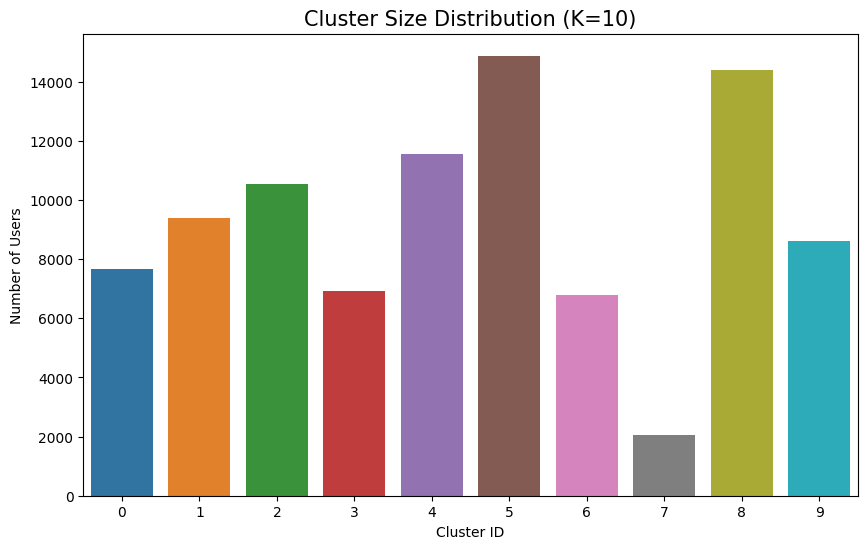


--- 3. 훈련 데이터에 'context' 적용 ---
훈련 데이터 'cluster_id' 및 'context' 생성 완료.
✅ 훈련 데이터 저장 완료 -> renttherunway_clustered.csv

--- 4. 테스트 데이터 전처리 및 예측 ---
테스트 데이터 'modcloth_processed_final.csv' 로드 (18,416건)
테스트 데이터 예측 완료.
테스트 데이터 'cluster_id' 및 'context' 생성 완료.
✅ 테스트 데이터 저장 완료 -> modcloth_clustered.csv

--- 모든 작업 완료 ---


In [ ]:
import pandas as pd
import numpy as np
import sys
import traceback
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt # [신규] 시각화
import seaborn as sns             # [신규] 시각화
try:
    from kmodes.kprototypes import KPrototypes # K-Prototypes 임포트
except ImportError:
    print("[알림] 'kmodes' 라이브러리를 설치합니다.")
    print("설치 완료 후 이 셀을 다시 실행해주세요.")
    # !pip install kmodes
    # sys.exit()

# --- 0. 설정 ---

K_CLUSTERS = 10

CLUSTER_FEATURES = ['height_cm', 'size_scaled_0_to_10', 'bra size', 'cup size']
NUMERICAL_FEATURES = ['height_cm', 'size_scaled_0_to_10', 'bra size']
CATEGORICAL_FEATURES = ['cup size']

in_train_file = "renttherunway_processed_final.csv"
in_test_file = "modcloth_processed_final.csv"

out_train_file = "renttherunway_clustered.csv"
out_test_file = "modcloth_clustered.csv"

print(f"--- 2단계: [수정] 유저 그룹화 (K-Prototypes, bra size=Numerical) 시작 ---")

try:
    # --- 1. 훈련 데이터 로드 및 전처리 ---
    print(f"훈련 데이터 '{in_train_file}' 로드 중...")
    df_train = pd.read_csv(in_train_file)
    df_train.columns = df_train.columns.str.strip()
    print(f"훈련 데이터 {len(df_train):,}건 로드 완료.")

    print("--- 훈련 데이터 전처리 (결측치 처리 및 스케일링) ---")

    # 1a. 클러스터링용 데이터 추출 (원본 복사)
    df_train_cluster_data = df_train[CLUSTER_FEATURES].copy()

    # 1b. 범주형 데이터 타입 변환 (str) - 'cup size'만
    df_train_cluster_data[CATEGORICAL_FEATURES] = df_train_cluster_data[CATEGORICAL_FEATURES].astype(str)

    # 1c. 숫자형 데이터 타입 변환 (float) - 'bra size' 포함
    for col in NUMERICAL_FEATURES:
        df_train_cluster_data[col] = pd.to_numeric(df_train_cluster_data[col], errors='coerce')

    # 1d. 숫자형 데이터 결측치 처리 (SimpleImputer)
    num_imputer = SimpleImputer(strategy='median')
    df_train_cluster_data[NUMERICAL_FEATURES] = num_imputer.fit_transform(
        df_train_cluster_data[NUMERICAL_FEATURES]
    )

    # 1e. 숫자형 데이터 스케일링 (StandardScaler)
    scaler = StandardScaler()
    df_train_cluster_data[NUMERICAL_FEATURES] = scaler.fit_transform(
        df_train_cluster_data[NUMERICAL_FEATURES]
    )

    # 1f. K-Prototypes 입력용 Matrix 생성
    train_matrix = df_train_cluster_data.values

    # 1g. 범주형 데이터의 컬럼 인덱스 찾기
    categorical_indices = [df_train_cluster_data.columns.get_loc(c) for c in CATEGORICAL_FEATURES]

    print(f"전처리 완료된 데이터 {len(train_matrix):,}건 준비.")
    print(f"숫자형 피처: {NUMERICAL_FEATURES}")
    print(f"범주형 피처: {CATEGORICAL_FEATURES} (인덱스: {categorical_indices})")


    # --- 2. 최종 모델 훈련 (K=10) ---
    print(f"\n--- 최종 모델 훈련 (K={K_CLUSTERS}) 시작 ---")

    kproto_final = KPrototypes(
        n_clusters=K_CLUSTERS,
        init='Huang',
        n_init=10,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )

    clusters_train = kproto_final.fit_predict(train_matrix, categorical=categorical_indices)
    print("최종 모델 훈련 완료.")


    # --- [신규] 2a. 시각화 섹션 ---
    print("\n--- [신규] 2a. 클러스터링 결과 시각화 ---")

    # 원본 데이터(df_train)에 클러스터 ID 임시 할당 (시각화용)
    df_train.loc[df_train_cluster_data.index, 'cluster_id'] = clusters_train
    # (결측치 등으로 클러스터링에서 제외된 유저는 cluster_id가 NaN일 것임)
    df_train_viz = df_train.dropna(subset=['cluster_id'])
    df_train_viz['cluster_id'] = df_train_viz['cluster_id'].astype(int)

    # 시각화 1: 클러스터별 인원 수 (Bar Chart)
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_train_viz, x='cluster_id', palette='tab10')
    plt.title(f'Cluster Size Distribution (K={K_CLUSTERS})', fontsize=15)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Users')
    plt.show()


    # --- 3. 훈련 데이터에 클러스터 및 Context 적용 ---
    print("\n--- 3. 훈련 데이터에 'context' 적용 ---")

    # (시각화에서 이미 cluster_id를 할당했지만, 혹시 모를 전체 데이터 대상으로 한번 더 실행)
    df_train.loc[df_train_cluster_data.index, 'cluster_id'] = clusters_train

    df_train['cluster_id'] = df_train['cluster_id'].astype(float).astype('Int64')
    df_train['context'] = 'cluster_' + df_train['cluster_id'].astype(str) + '_' + df_train['rented for']

    print(f"훈련 데이터 'cluster_id' 및 'context' 생성 완료.")

    df_train.to_csv(out_train_file, index=False, encoding='utf-8-sig')
    print(f"✅ 훈련 데이터 저장 완료 -> {out_train_file}")


    # --- 4. 테스트 데이터(Test) 준비 및 예측 ---
    print(f"\n--- 4. 테스트 데이터 전처리 및 예측 ---")

    df_test = pd.read_csv(in_test_file)
    df_test.columns = df_test.columns.str.strip()
    print(f"테스트 데이터 '{in_test_file}' 로드 ({len(df_test):,}건)")

    # [수정] 4b. '.dropna()' 제거
    df_test_cluster_data = df_test[CLUSTER_FEATURES].copy()

    # 4c. 범주형 데이터 타입 변환 (str) - 'cup size'만
    df_test_cluster_data[CATEGORICAL_FEATURES] = df_test_cluster_data[CATEGORICAL_FEATURES].astype(str)

    # 4d. 숫자형 데이터 타입 변환 (float) - 'bra size' 포함
    for col in NUMERICAL_FEATURES:
        df_test_cluster_data[col] = pd.to_numeric(df_test_cluster_data[col], errors='coerce')

    # 4e. 숫자형 데이터 결측치 처리 (훈련 Imputer로 transform)
    df_test_cluster_data[NUMERICAL_FEATURES] = num_imputer.transform(
        df_test_cluster_data[NUMERICAL_FEATURES]
    )

    # 4f. 숫자형 데이터 스케일링 (훈련 Scaler로 transform)
    df_test_cluster_data[NUMERICAL_FEATURES] = scaler.transform(
        df_test_cluster_data[NUMERICAL_FEATURES]
    )

    # 4g. K-Prototypes 입력용 Matrix 생성
    test_matrix = df_test_cluster_data.values

    # 4h. 테스트 데이터 예측
    clusters_test = kproto_final.predict(test_matrix, categorical=categorical_indices)
    print("테스트 데이터 예측 완료.")


    # --- 5. 테스트 데이터에 클러스터 및 Context 적용 ---

    df_test.loc[df_test_cluster_data.index, 'cluster_id'] = clusters_test

    df_test['cluster_id'] = df_test['cluster_id'].astype(float).astype('Int64')
    df_test['context'] = 'cluster_' + df_test['cluster_id'].astype(str) + '_' + df_test['rented for']

    print(f"테스트 데이터 'cluster_id' 및 'context' 생성 완료.")

    df_test.to_csv(out_test_file, index=False, encoding='utf-8-sig')
    print(f"✅ 테스트 데이터 저장 완료 -> {out_test_file}")

    print("\n--- 모든 작업 완료 ---")

except ImportError as e:
    print("[오류] 'kmodes' 라이브러리가 설치되지 않았습니다.")
    print("코랩 셀에서 '!pip install kmodes'를 실행해주세요.")
except FileNotFoundError as e:
    print(f"[파일 로드 오류] {e}.")
    print("1단계 출력 파일인 'renttherunway_processed_final.csv' 또는 'modcloth_processed_final.csv'가 필요합니다.")
except KeyError as e:
    print(f"[KeyError] {e}. 1단계 파일에 {CLUSTER_FEATURES} 컬럼이 모두 있는지 확인하세요.")
    print("   (참고: 1단계 스크립트가 'size_scaled_0_to_10'을 생성했는지 확인)")
except Exception as e:
    print(f"처리 중 예기치 않은 오류 발생: {e}")
    traceback.print_exc()

CF Score Model (rating + fit)

In [ ]:
print("--- 3단계: [수정] CF Score (Rating + Fit + n_USERS) 모델 구축 ---")

# --- 1. 데이터 로드 ---
in_train_clustered = "renttherunway_clustered.csv"

try:
    df_train = pd.read_csv(in_train_clustered, dtype={'product_code': str, 'user_id': str})

    # 컬럼명 공백 제거
    df_train.columns = df_train.columns.str.strip()

    if 'fit' not in df_train.columns:
        print("[오류] 'renttherunway_clustered.csv'에서 'fit' 컬럼을 찾을 수 없습니다!")
        print(f"  > 찾은 컬럼: {df_train.columns.tolist()}")
        # sys.exit()

    print(f"클러스터링된 훈련 데이터 {len(df_train):,}건 로드 및 컬럼명 정제 완료.")

except FileNotFoundError as e:
    print(f"[오류] {e}. 'renttherunway_clustered.csv' 파일이 필요합니다.")
    # sys.exit()

# --- 2. Context 정의 ---
df_train['context'] = 'cluster_' + df_train['cluster_id'].astype(str) + \
                      '_rent_' + df_train['rented for'].astype(str)
print("Context 컬럼 생성 완료.")

# --- 3. 'rating'과 'fit'에 대한 신뢰도 보정 점수 계산 ---
print("Context-Item 별 '신뢰도 보정' 평점 (Rating + Fit) 계산 중...")

# 3a. 입력값 전처리
df_train['rating'] = pd.to_numeric(df_train['rating'], errors='coerce')

def map_fit_score(fit_value):
    if fit_value == 'fit':
        return 1
    elif fit_value in ['small', 'large']:
        return -1
    else:
        return 0 # (e.g., NaN 또는 'nan')

df_train['fit_numeric'] = df_train['fit'].apply(map_fit_score)
df_train = df_train.dropna(subset=['rating']) # 평점이 없는 리뷰는 제외

# 3b. 글로벌 평균(m) 및 신뢰도 상수(C) 정의
m_rating = df_train['rating'].mean()
m_fit = df_train['fit_numeric'].mean()
C = 5 # 신뢰도 상수

print(f"  글로벌 평균 평점(m_rating) = {m_rating:.2f}")
print(f"  글로벌 평균 핏(m_fit) = {m_fit:.2f}")
print(f"  신뢰도 상수(C) = {C}")

# 3c. (Context, Product) 그룹별로 '평균(R)'과 '고유 사용자 수(n)' 집계
df_agg = df_train.groupby(
    ['context', 'product_code']
).agg(
    # [수정] 'rating'의 개수가 아닌, 'user_id'의 고유(unique) 개수를 신뢰도(n)로 사용
    n_users=('user_id', 'nunique'), # 'n_reviews' -> 'n_users'
    R_rating=('rating', 'mean'),   # 'rating' 컬럼의 평균
    R_fit=('fit_numeric', 'mean')  # 'fit' 컬럼의 평균
).reset_index()

# 3d. 베이지안 스무딩 (신뢰도 보정) 공식 적용
# [수정] 'n' 변수가 'n_reviews'가 아닌 'n_users'를 사용하도록 변경
n = df_agg['n_users']
# Rating Score 보정
df_agg['cf_rating_score'] = ((C * m_rating) + (n * df_agg['R_rating'])) / (C + n)
# Fit Score 보정
df_agg['cf_fit_score'] = ((C * m_fit) + (n * df_agg['R_fit'])) / (C + n)

# 3e. [핵심 모델] 완성
# [수정] 'n_reviews' -> 'n_users'
cf_score_table = df_agg[['context', 'product_code', 'cf_rating_score', 'cf_fit_score', 'n_users']]

print("신뢰도 보정된 (Rating + Fit) 세부 평점 테이블(CF Score Model) 생성 완료.")


# --- 4. "그룹(Context)별" '전체' 평균 평점 "표"로 출력 ---
print("\n--- 4. '그룹별 전체 평균 평점' 요약 (표) ---")

context_overall_scores = cf_score_table.groupby('context')['cf_rating_score'].mean().reset_index()
context_overall_scores = context_overall_scores.rename(columns={'cf_rating_score': 'overall_avg_rating'})
context_scores_sorted = context_overall_scores.sort_values(by='overall_avg_rating', ascending=False)

print("\n[표 1] 평점이 가장 후한 그룹 (Top 10)")
print(context_scores_sorted.head(10).to_string())
print("\n[표 2] 평점이 가장 짠 그룹 (Bottom 10)")
print(context_scores_sorted.tail(10).to_string())


# --- 5. CF Score "세부" 모델 저장 ---
out_model_file = "cf_model_final.csv"
cf_score_table.to_csv(out_model_file, index=False, encoding='utf-8-sig')

print("\n--- 3단계 (CF) + 'Fit' + 'n_users' 완료 ---")
print(f"✅ '세부' 평점 모델 저장: {out_model_file} ({len(cf_score_table):,}줄)")
print("\n--- '세부' 평점 예시 데이터 (4단계에서 이 파일을 사용합니다) ---")
print(cf_score_table.head())

--- 3단계: [수정] CF Score (Rating + Fit + n_USERS) 모델 구축 ---
클러스터링된 훈련 데이터 92,879건 로드 및 컬럼명 정제 완료.
Context 컬럼 생성 완료.
Context-Item 별 '신뢰도 보정' 평점 (Rating + Fit) 계산 중...
  글로벌 평균 평점(m_rating) = 9.05
  글로벌 평균 핏(m_fit) = 0.43
  신뢰도 상수(C) = 5
신뢰도 보정된 (Rating + Fit) 세부 평점 테이블(CF Score Model) 생성 완료.

--- 4. '그룹별 전체 평균 평점' 요약 (표) ---

[표 1] 평점이 가장 후한 그룹 (Top 10)
                           context  overall_avg_rating
77         cluster_8_rent_vacation            9.311296
86         cluster_9_rent_vacation            9.206424
25  cluster_2_rent_wedding_general            9.158128
23         cluster_2_rent_vacation            9.153091
3     cluster_0_rent_party_general            9.143695
58   cluster_6_rent_party_specific            9.141667
41         cluster_4_rent_vacation            9.136702
71             cluster_7_rent_work            9.130898
59         cluster_6_rent_vacation            9.127773
66    cluster_7_rent_party_general            9.117808

[표 2] 평점이 가장 짠 그룹 (Bottom 10)
           

## XGboost 없이 가중합으로만 Hybrid (실제 hybrid는 아래 코드 사용 예정)

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer # [수정-BERT] TF-IDF 대신 BERT 임포트

warnings.filterwarnings('ignore')

print("--- 4단계: [수정] 3-Hybrid (Rating + Fit + BERT-Style) 추천 시작 ---")

# --- 1. 모든 재료 로드 ---
try:
    dtype_spec = {'product_code': str}

    # 3단계(V2)의 결과물 (n_users, fit 점수 포함)
    df_cf_model = pd.read_csv("cf_model_final.csv", dtype=dtype_spec)
    df_test_users = pd.read_csv("modcloth_clustered.csv", dtype=dtype_spec)
    df_train_users = pd.read_csv("renttherunway_clustered.csv", dtype=dtype_spec)
    df_articles = pd.read_csv("articles.csv", encoding='latin-1', dtype=dtype_spec)

    # 0-padding 통일
    df_cf_model['product_code'] = df_cf_model['product_code'].str.zfill(10)
    df_test_users['product_code'] = df_test_users['product_code'].str.zfill(10)
    df_train_users['product_code'] = df_train_users['product_code'].str.zfill(10)
    df_articles['product_code'] = df_articles['product_code'].str.zfill(10)

    print("모든 모델 및 데이터 로드 완료. ('product_code'는 0-padded str로 통일)")
    print(f"  CF Score 모델 (Rating+Fit): {len(df_cf_model):,}건")

except FileNotFoundError as e:
    print(f"[오류] {e}")
    print("필요한 파일 4개(cf_model_final, modcloth_clustered, renttherunway_clustered, articles)가 모두 필요합니다.")
    # sys.exit()

# --- 2. 아이템 스타일 모델 구축 (CBF-Style) [수정-BERT] ---
print("\n--- 아이템 스타일(CBF) 모델 (BERT) 구축 중... ---")

# 2a. 'Dress'만 필터링
df_dress_articles = df_articles[df_articles['product_type_name'] == 'Dress'].copy()
df_dress_articles['prod_name'] = df_dress_articles['prod_name'].fillna("no name")
df_dress_articles['detail_desc'] = df_dress_articles['detail_desc'].fillna("no description")

# 2b. '이름' + '상세설명'을 합쳐서 스타일 텍스트로 사용
df_dress_articles['style_text'] = df_dress_articles['prod_name'] + " " + df_dress_articles['detail_desc']

# 2c. [수정-BERT] BERT 모델 로드
# (다국어 지원 및 문장 유사도에 특화된 경량화 모델)
bert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("BERT 모델 로드 완료.")

# 2d. [수정-BERT] 'style_text'를 BERT 벡터로 변환 (Embedding)
# (GPU 사용 시 몇 분 정도 소요될 수 있습니다)
style_text_corpus = df_dress_articles['style_text'].tolist()
bert_matrix = bert_model.encode(style_text_corpus, show_progress_bar=True)

print(f"아이템 스타일 모델 (BERT) 구축 완료. (총 {bert_matrix.shape[0]}개 드레스, {bert_matrix.shape[1]}개 차원)")

# 2e. (product_code) <-> (bert_matrix 인덱스) 매핑
item_style_model = pd.DataFrame({
    'product_code': df_dress_articles['product_code'],
    'prod_name': df_dress_articles['prod_name']
}).reset_index(drop=True)
item_index_map = pd.Series(item_style_model.index, index=item_style_model['product_code']).to_dict()


# --- 3. 테스트 유저 1명 선정 및 추천 ---
print("\n--- 테스트 유저 1명에 대한 추천 시뮬레이션 ---")

try:
    test_user = df_test_users.iloc[5]
    print(f"테스트 유저 선정 (iloc[5]):")
    print(f"  - Cluster ID: {test_user['cluster_id']}")
    print(f"  - Rented For: {test_user['rented for']}")
    actual_item_rented = test_user['product_code']
    print(f"  - [정답 아이템]: {actual_item_rented} (이 아이템을 맞혀야 함)")

except IndexError:
    print("[오류] 테스트 유저가 없습니다. iloc[0]으로 다시 시도합니다.")
    test_user = df_test_users.iloc[0]

user_cluster = f"cluster_{test_user['cluster_id']}"
user_context = f"{user_cluster}_rent_{test_user['rented for']}"
print(f"  -> 유저 Context: '{user_context}'")

# --- 4. 점수 1 & 2: CF Score (Rating + Fit) 조회 ---
print("\n--- 4. 점수 1 & 2 (CF-Rating, CF-Fit) 조회 중... ---")

# 'n_users' 컬럼명 확인
if 'n_users' not in df_cf_model.columns and 'n_reviews' in df_cf_model.columns:
    print("[정보] 'n_users' 컬럼이 없어 'n_reviews'를 사용합니다.")
    df_cf_model = df_cf_model.rename(columns={'n_reviews': 'n_users'})

user_cf_scores = df_cf_model[
    df_cf_model['context'] == user_context
][['product_code', 'cf_rating_score', 'cf_fit_score', 'n_users']]

if user_cf_scores.empty:
    print(f"[정보] '{user_context}'에 대한 CF Score가 없습니다.")
else:
    print(f"'{user_context}'의 CF Score (Rating+Fit) {len(user_cf_scores):,}건 조회 완료.")

# --- 5. 점수 3: CBF Score (Style) 계산 ---
print("\n--- 5. 점수 3 (CBF-Style) 계산 중... ---")

df_train_users.columns = df_train_users.columns.str.strip()
df_train_users['context'] = 'cluster_' + df_train_users['cluster_id'].astype(str) + \
                            '_rent_' + df_train_users['rented for'].astype(str)

context_product_codes = df_train_users[
    df_train_users['context'] == user_context
]['product_code']

if context_product_codes.empty:
    print(f"[정보] 훈련 데이터에 '{user_context}'가 없습니다. '{user_cluster}'로 범위를 넓혀 재시도합니다.")
    context_product_codes = df_train_users[
        df_train_users['cluster_id'] == test_user['cluster_id']
    ]['product_code']

context_item_indices = [item_index_map.get(code) for code in context_product_codes if item_index_map.get(code) is not None]

if not context_item_indices:
    print(f"[경고] 체형 클러스터({user_cluster}) 기준으로도 선호 아이템 정보를 찾을 수 없습니다.")
    # [수정-BERT] BERT 매트릭스의 차원(shape[1])에 맞춰 0벡터 생성
    user_style_vector = np.zeros((bert_matrix.shape[1],))
else:
    # [수정-BERT] bert_matrix에서 유저의 평균 스타일 벡터 계산
    user_style_vector = bert_matrix[context_item_indices].mean(axis=0)
    print(f"평균 스타일 벡터 계산 완료. (훈련 데이터 {len(context_item_indices)}개 아이템 기반)")

# [수정-BERT] 1D 벡터(user_style_vector)를 2D로 [vector] 변환하여 cosine_similarity 계산
cbf_scores_raw = cosine_similarity([user_style_vector], bert_matrix)

user_cbf_scores = item_style_model[['product_code', 'prod_name']].copy()
user_cbf_scores['cbf_style_score'] = cbf_scores_raw.flatten()
print(f"모든 아이템({len(user_cbf_scores):,})에 대한 CBF-Style Score 계산 완료.")


# --- 6. 최종 점수 합산 (3-Hybrid) ---
print("\n--- 6. (Rating + Fit + Style) 점수 합산 (Hybrid) ---")

W_RATING = 0.5  # 평점 40%
W_FIT = 0.3     # 핏 40%
W_STYLE = 0.2   # 스타일 20%

final_recommendations = pd.merge(
    user_cbf_scores,
    user_cf_scores,
    on='product_code',
    how='left'
)

final_recommendations['cf_rating_score'] = final_recommendations['cf_rating_score'].fillna(0.0)
final_recommendations['cf_fit_score'] = final_recommendations['cf_fit_score'].fillna(0.0)
final_recommendations['n_users'] = final_recommendations['n_users'].fillna(0).astype(int)

final_recommendations['final_score'] = (W_RATING * final_recommendations['cf_rating_score']) + \
                                       (W_FIT * final_recommendations['cf_fit_score']) + \
                                       (W_STYLE * final_recommendations['cbf_style_score'])

# [추가] CF 스코어가 있는 아이템만 사용
# n_users가 0보다 큰 아이템만 필터링 (CF 모델에 있는 아이템)
final_recommendations = final_recommendations[final_recommendations['n_users'] > 0]

# [추가] 중복 제거
final_recommendations = final_recommendations.drop_duplicates(subset=['product_code'])

# 점수순 정렬
final_recommendations = final_recommendations.sort_values(by='final_score', ascending=False)



# --- 7. 결과 출력 ---
print(f"\n--- [최종 추천 결과] for Context: '{user_context}' ---")
print(f"(가중치: Rating={W_RATING*100}%, Fit={W_FIT*100}%, Style={W_STYLE*100}%)")
print(f"(필터: n_users > 0, CF 모델에 있는 아이템만 사용)")

print(final_recommendations[[
    'prod_name', 'product_code', 'final_score',
    'cf_rating_score', 'cf_fit_score', 'cbf_style_score', 'n_users'
]].head(10).to_string())



# --- 8. 전체 테스트 유저에 대한 성능 평가 ---
print("\n" + "="*70)
print("--- 8. 전체 테스트 유저 대상 랭킹 평가 (Hybrid Model) ---")
print("="*70)

from tqdm import tqdm

def recommend_for_user(test_user_row, top_k=10):
    """
    주어진 테스트 유저에 대해 Top-K 아이템을 추천하는 함수
    """
    user_cluster = f"cluster_{test_user_row['cluster_id']}"
    user_context = f"{user_cluster}_rent_{test_user_row['rented for']}"

    # 1. CF Score 조회
    user_cf_scores = df_cf_model[
        df_cf_model['context'] == user_context
    ][['product_code', 'cf_rating_score', 'cf_fit_score', 'n_users']]

    # 2. CBF Score 계산
    context_product_codes = df_train_users[
        df_train_users['context'] == user_context
    ]['product_code']

    if context_product_codes.empty:
        context_product_codes = df_train_users[
            df_train_users['cluster_id'] == test_user_row['cluster_id']
        ]['product_code']

    context_item_indices = [
        item_index_map.get(code) for code in context_product_codes
        if item_index_map.get(code) is not None
    ]

    if not context_item_indices:
        user_style_vector = np.zeros((bert_matrix.shape[1],))
    else:
        user_style_vector = bert_matrix[context_item_indices].mean(axis=0)

    cbf_scores_raw = cosine_similarity([user_style_vector], bert_matrix)
    user_cbf_scores = item_style_model[['product_code', 'prod_name']].copy()
    user_cbf_scores['cbf_style_score'] = cbf_scores_raw.flatten()

    # 3. 최종 점수 합산
    final_recs = pd.merge(
        user_cbf_scores,
        user_cf_scores,
        on='product_code',
        how='left'
    )

    final_recs['cf_rating_score'] = final_recs['cf_rating_score'].fillna(0.0)
    final_recs['cf_fit_score'] = final_recs['cf_fit_score'].fillna(0.0)
    final_recs['n_users'] = final_recs['n_users'].fillna(0).astype(int)

    final_recs['final_score'] = (W_RATING * final_recs['cf_rating_score']) + \
                                (W_FIT * final_recs['cf_fit_score']) + \
                                (W_STYLE * final_recs['cbf_style_score'])

    # CF 모델에 있는 아이템만 사용 (n_users > 0)
    final_recs = final_recs[final_recs['n_users'] > 0]
    final_recs = final_recs.drop_duplicates(subset=['product_code'])
    final_recs = final_recs.sort_values(by='final_score', ascending=False)

    # Top-K 추천
    top_k_items = final_recs.head(top_k)['product_code'].tolist()
    return top_k_items


# 랭킹 평가 지표 계산
def calculate_ranking_metrics(test_df, k=10):
    """
    Recall@K, MRR@K, HitRate@K 계산
    """
    recalls = []
    mrrs = []
    hits = []

    for idx in tqdm(range(len(test_df)), desc="Evaluating"):
        test_user_row = test_df.iloc[idx]
        actual_item = test_user_row['product_code']

        try:
            recommended_items = recommend_for_user(test_user_row, top_k=k)
        except Exception as e:
            # 추천 실패 시 빈 리스트
            recommended_items = []

        # Recall@K
        if actual_item in recommended_items:
            recalls.append(1.0)
            # MRR@K (첫 번째 정답의 순위)
            rank = recommended_items.index(actual_item) + 1
            mrrs.append(1.0 / rank)
            hits.append(1)
        else:
            recalls.append(0.0)
            mrrs.append(0.0)
            hits.append(0)

    avg_recall = np.mean(recalls)
    avg_mrr = np.mean(mrrs)
    hit_rate = np.mean(hits)

    return {
        'Recall@K': avg_recall,
        'MRR@K': avg_mrr,
        'HitRate@K': hit_rate,
        'Total_Evaluated': len(test_df)
    }


# 평가 실행
print(f"\n전체 테스트 유저 {len(df_test_users):,}명에 대해 평가 중...")
metrics = calculate_ranking_metrics(df_test_users, k=10)

print("\n" + "="*70)
print("[HYBRID MODEL - RANKING METRICS]")
print("="*70)
print(f"  Recall@10:   {metrics['Recall@K']:.4f}")
print(f"  MRR@10:      {metrics['MRR@K']:.4f}")
print(f"  HitRate@10:  {metrics['HitRate@K']:.4f}")
print(f"  EVALUATED:   {metrics['Total_Evaluated']:,}")
print("="*70)


# --- 9. XGBoost vs Hybrid 비교 ---
print("\n" + "="*70)
print("--- 9. 모델 비교 (XGBoost vs Hybrid) ---")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['Recall@10', 'MRR@10', 'HitRate@10'],
    'XGBoost': [0.0131, 0.0041, 0.0131],
    'Hybrid': [
        metrics['Recall@K'],
        metrics['MRR@K'],
        metrics['HitRate@K']
    ]
})

comparison_df['Improvement (%)'] = (
    (comparison_df['Hybrid'] - comparison_df['XGBoost']) / comparison_df['XGBoost'] * 100
)

print(comparison_df.to_string(index=False))
print("="*70)

print("\n--- 완료 ---")


--- 4단계: [수정] 3-Hybrid (Rating + Fit + BERT-Style) 추천 시작 ---
모든 모델 및 데이터 로드 완료. ('product_code'는 0-padded str로 통일)
  CF Score 모델 (Rating+Fit): 39,403건

--- 아이템 스타일(CBF) 모델 (BERT) 구축 중... ---


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

BERT 모델 로드 완료.


Batches:   0%|          | 0/324 [00:00<?, ?it/s]

아이템 스타일 모델 (BERT) 구축 완료. (총 10362개 드레스, 384개 차원)

--- 테스트 유저 1명에 대한 추천 시뮬레이션 ---
테스트 유저 선정 (iloc[5]):
  - Cluster ID: 8
  - Rented For: wedding_black_tie
  - [정답 아이템]: 0000543310 (이 아이템을 맞혀야 함)
  -> 유저 Context: 'cluster_8_rent_wedding_black_tie'

--- 4. 점수 1 & 2 (CF-Rating, CF-Fit) 조회 중... ---
'cluster_8_rent_wedding_black_tie'의 CF Score (Rating+Fit) 2,797건 조회 완료.

--- 5. 점수 3 (CBF-Style) 계산 중... ---
평균 스타일 벡터 계산 완료. (훈련 데이터 9390개 아이템 기반)
모든 아이템(10,362)에 대한 CBF-Style Score 계산 완료.

--- 6. (Rating + Fit + Style) 점수 합산 (Hybrid) ---

--- [최종 추천 결과] for Context: 'cluster_8_rent_wedding_black_tie' ---
(가중치: Rating=50.0%, Fit=30.0%, Style=20.0%)
(필터: n_users > 0, CF 모델에 있는 아이템만 사용)
                      prod_name product_code  final_score  cf_rating_score  cf_fit_score  cbf_style_score  n_users
8382                 Coco Dress   0000852671     5.213774         9.721567      0.598189         0.867668       12
3903   PE LOUIS KNITTED DRESS 2   0000697491     5.177913         9.569694      0.7426

Evaluating: 100%|██████████| 18416/18416 [19:45<00:00, 15.53it/s]


[HYBRID MODEL - RANKING METRICS]
  Recall@10:   0.0127
  MRR@10:      0.0038
  HitRate@10:  0.0127
  EVALUATED:   18,416

--- 9. 모델 비교 (XGBoost vs Hybrid) ---
    Metric  XGBoost   Hybrid  Improvement (%)
 Recall@10   0.0131 0.012652        -3.419529
    MRR@10   0.0041 0.003815        -6.944251
HitRate@10   0.0131 0.012652        -3.419529

--- 완료 ---


In [ ]:
!pip install sentence-transformers

# XG Boost +위의 Hybrid Model

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tqdm import tqdm # 진행률 표시줄


# =========================
# XGBoost + BERT (Context 형식 통일 - 오타 수정)
# =========================

# =========================
# 설정
# =========================
FILE_TRAIN_CLU = "renttherunway_clustered.csv"
FILE_TEST_CLU  = "modcloth_clustered.csv"
FILE_CF_FINAL  = "cf_model_final.csv"
FILE_ARTICLES  = "articles.csv"
TOPK_EVAL = 10

# =========================
# 1) 데이터 로드
# =========================
print("--- 1. 데이터 로드 및 전처리 ---")
dtype_spec = {"product_code": str, "user_id": str}

df_train = pd.read_csv(FILE_TRAIN_CLU, dtype=dtype_spec)
df_test  = pd.read_csv(FILE_TEST_CLU,  dtype=dtype_spec)
df_cf    = pd.read_csv(FILE_CF_FINAL,  dtype=dtype_spec)
df_art   = pd.read_csv(FILE_ARTICLES,  dtype=dtype_spec, encoding="latin-1")

for df in (df_train, df_test, df_cf, df_art):
    df.columns = df.columns.str.strip()
    if "product_code" in df.columns:
        df["product_code"] = df["product_code"].astype(str).str.zfill(10)

# Train context 확인
if "context" in df_train.columns:
    train_ctx_sample = df_train["context"].iloc[0]
    print(f"[정보] Train context 샘플: {train_ctx_sample}")
else:
    df_train["context"] = 'cluster_' + df_train["cluster_id"].astype(str) + '_' + df_train["rented for"]
    train_ctx_sample = df_train["context"].iloc[0]
    print(f"[정보] Train context 생성: {train_ctx_sample}")

if "context" not in df_test.columns:
    df_test["context"] = 'cluster_' + df_test["cluster_id"].astype(str) + '_' + df_test["rented for"]

# [오타 수정] CF context 변환
if "context" in df_cf.columns:
    cf_ctx_sample = df_cf["context"].iloc[0]  # 오타 수정: cf_cf_ctx_sample -> cf_ctx_sample
    print(f"[정보] CF context 원본: {cf_ctx_sample}")

    # CF context에 "rent_"가 포함되어 있는지 확인
    if "_rent_" in cf_ctx_sample:
        print("[수정] CF context에서 '_rent_' 제거 중...")
        # "cluster_0_rent_date_general" -> "cluster_0_date_general"
        df_cf["context"] = df_cf["context"].str.replace("_rent_", "_", regex=False)
        print(f"[수정 후] CF context: {df_cf['context'].iloc[0]}")
    else:
        print("[정보] CF context는 이미 올바른 형식입니다.")
else:
    # CF에 context가 없으면 생성
    print("[경고] CF 파일에 context 컬럼이 없습니다. 생성합니다.")
    df_cf["context"] = 'cluster_' + df_cf["cluster_id"].astype(str) + '_' + df_cf["rented for"]

# CF 정규화
if "n_users" not in df_cf.columns and "n_reviews" in df_cf.columns:
    df_cf = df_cf.rename(columns={"n_reviews":"n_users"})
df_cf["n_users"] = pd.to_numeric(df_cf["n_users"], errors="coerce").fillna(0).astype(int)

print(f"[LOAD] train={len(df_train):,}, test={len(df_test):,}, cf={len(df_cf):,}, articles={len(df_art):,}")

# [디버깅] Context 형식 재확인
print(f"\n[디버깅] Context 샘플 (수정 후):")
print(f"  Train: {df_train['context'].iloc[0]}")
print(f"  CF:    {df_cf['context'].iloc[0]}")
print(f"  Test:  {df_test['context'].iloc[0]}")

# [중요] Context 매칭률 확인
print(f"\n[디버깅] Context 통계:")
print(f"  Train 고유 context: {df_train['context'].nunique():,}")
print(f"  CF 고유 context:    {df_cf['context'].nunique():,}")
print(f"  Test 고유 context:  {df_test['context'].nunique():,}")

train_contexts = set(df_train['context'].unique())
cf_contexts = set(df_cf['context'].unique())
common_contexts = train_contexts & cf_contexts
print(f"  Train-CF 공통 context: {len(common_contexts):,} / {len(train_contexts):,} ({100*len(common_contexts)/len(train_contexts):.1f}%)")

if len(common_contexts) == 0:
    print("\n[오류] Train과 CF의 context가 전혀 매칭되지 않습니다!")
    print("  Train context 예시 5개:")
    for ctx in list(train_contexts)[:5]:
        print(f"    - {ctx}")
    print("  CF context 예시 5개:")
    for ctx in list(cf_contexts)[:5]:
        print(f"    - {ctx}")

# =========================
# 2) CBF: BERT 모델 구축
# =========================
print("\n--- 2. CBF: BERT 스타일 모델 구축 ---")

train_product_codes = set(df_train["product_code"].unique())
print(f"  - 훈련 데이터의 고유 아이템 수: {len(train_product_codes):,}")

df_art_filtered = df_art[df_art["product_code"].isin(train_product_codes)].copy()
print(f"  - Articles에서 매칭된 아이템: {len(df_art_filtered):,}")

df_dress = df_art_filtered[df_art_filtered["product_type_name"] == 'Dress'].copy()
print(f"  - Dress 타입 아이템: {len(df_dress):,}")

if df_dress.empty:
    print("[경고] Dress 타입이 없어 모든 타입 사용")
    df_dress = df_art_filtered.copy()

df_dress["prod_name"] = df_dress["prod_name"].fillna("no name").astype(str)
df_dress["detail_desc"] = df_dress.get("detail_desc", pd.Series(index=df_dress.index)).fillna("no description").astype(str)
df_dress["style_text"] = (df_dress["prod_name"] + " " + df_dress["detail_desc"]).str.strip()
df_dress = df_dress.drop_duplicates(subset=["product_code"]).reset_index(drop=True)

bert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("BERT 모델 로드 완료.")
style_text_corpus = df_dress['style_text'].tolist()
bert_matrix = bert_model.encode(style_text_corpus, show_progress_bar=True)

n_items, n_dims = bert_matrix.shape
item_codes = df_dress["product_code"].tolist()
item_index_map = {code: i for i, code in enumerate(item_codes)}
print(f"[CBF] BERT built: items={n_items:,}, dims={n_dims:,}")

# =========================
# 3) CBF 점수 계산 함수
# =========================
ctx2codes = (
    df_train[["context","product_code"]]
    .dropna()
    .groupby("context")["product_code"]
    .apply(list)
    .to_dict()
)

_cbf_cache = {}

def compute_cbf_for_context(ctx):
    if ctx in _cbf_cache:
        return _cbf_cache[ctx]

    codes = ctx2codes.get(ctx, [])
    idxs = [item_index_map.get(c) for c in codes if c in item_index_map]

    if not idxs:
        try:
            cluster_id = int(ctx.split("_")[1])
            fb_codes = df_train.loc[df_train["cluster_id"].astype(str) == str(cluster_id), "product_code"].tolist()
            idxs = [item_index_map.get(c) for c in fb_codes if c in item_index_map]
        except:
            idxs = []

    if not idxs:
        cbf = pd.DataFrame({
            "product_code": df_dress["product_code"].values,
            "cbf_style_score": np.zeros(n_items, dtype=float)
        })
    else:
        style_vec = bert_matrix[idxs].mean(axis=0).reshape(1, -1)
        scores = cosine_similarity(style_vec, bert_matrix).ravel()
        cbf = pd.DataFrame({
            "product_code": df_dress["product_code"].values,
            "cbf_style_score": scores
        })

    _cbf_cache[ctx] = cbf
    return cbf

# =========================
# 4) XGBoost 훈련 데이터 구성
# =========================
print("\n--- 3. XGBoost 훈련 데이터 구성 ---")
df_train["rating"] = pd.to_numeric(df_train["rating"], errors="coerce")
train_rows = df_train.dropna(subset=["rating","product_code","context"]).copy()

print(f"  - 전처리된 훈련 행: {len(train_rows):,}건")

# CF 병합
feat_train = (
    train_rows[["user_id","product_code","context","rating"]]
    .merge(
        df_cf[["context","product_code","cf_rating_score","cf_fit_score","n_users"]],
        on=["context","product_code"],
        how="left"
    )
)

print(f"  - CF 병합 후: {len(feat_train):,}건")

# CF 스코어 결측치 처리
feat_train["cf_rating_score"] = feat_train["cf_rating_score"].fillna(0.0)
feat_train["cf_fit_score"] = feat_train["cf_fit_score"].fillna(0.0)
feat_train["n_users"] = feat_train["n_users"].fillna(0).astype(int)

# CBF 피처 병합
print("  - CBF 스타일 피처 계산 중...")
unique_contexts = feat_train["context"].unique()

if len(unique_contexts) == 0:
    print("[오류] Context가 없습니다!")
else:
    cbf_all_contexts = []
    for ctx in tqdm(unique_contexts):
        cbf_df = compute_cbf_for_context(ctx)
        cbf_df["context"] = ctx
        cbf_all_contexts.append(cbf_df)

    if len(cbf_all_contexts) > 0:
        cbf_style_features = pd.concat(cbf_all_contexts, ignore_index=True)
        feat_train = feat_train.merge(
            cbf_style_features,
            on=["context", "product_code"],
            how="left"
        )
    else:
        feat_train["cbf_style_score"] = 0.0

print(f"  - CBF 병합 후: {len(feat_train):,}건")

# 피처 정리
feature_cols = ["cf_rating_score", "cf_fit_score", "n_users", "cbf_style_score"]
label_col = "rating"

feat_train["cbf_style_score"] = feat_train.get("cbf_style_score", 0.0).fillna(0.0)

# [디버깅] 피처 통계
print("\n[디버깅] 피처 통계:")
for col in feature_cols:
    if col in feat_train.columns:
        vals = feat_train[col].values
        non_zero = np.count_nonzero(vals)
        print(f"  {col}: mean={vals.mean():.4f}, std={vals.std():.4f}, non-zero={non_zero}/{len(vals)} ({100*non_zero/len(vals):.1f}%)")
    else:
        print(f"  {col}: [누락됨]")

# [경고] CF 피처 확인
if feat_train["cf_rating_score"].sum() == 0:
    print("\n[경고] CF Rating Score가 여전히 모두 0입니다!")
else:
    print("\n[성공] CF 피처가 정상적으로 로드되었습니다!")

X = feat_train[feature_cols].values
y = feat_train[label_col].values

X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\n  - X_train={X_tr.shape}, y_train={y_tr.shape}")

# =========================
# 5) XGBoost 학습
# =========================
print("\n--- 4. XGBoost 모델 학습 ---")

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.1,
    max_depth=5,
    n_estimators=1000,         # 많이 잡되
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50   # 50번 개선 없으면 중단
)

xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    verbose=50
)


pred = xgb_model.predict(X_va)
rmse = float(np.sqrt(mean_squared_error(y_va, pred)))
r2 = float(r2_score(y_va, pred))
print(f"\n[METRIC] RMSE={rmse:.4f} | R²={r2:.4f}")

print("\n[XGB] Feature Importance:")
imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print(imp_df.to_string(index=False))

# =========================
# 6) 추천 함수
# =========================
print("\n--- 5. 추천 함수 정의 ---")
def recommend_for_context(ctx, top_n=10):
    base = df_cf[df_cf["context"] == ctx][["product_code","cf_rating_score","cf_fit_score","n_users"]].copy()

    if base.empty:
        return pd.DataFrame(columns=["product_code","prod_name","final_score"])

    cbf_ctx = compute_cbf_for_context(ctx)
    base = base.merge(cbf_ctx, on="product_code", how="left").fillna({"cbf_style_score":0.0})

    X_all = base[feature_cols].values
    base["final_score"] = xgb_model.predict(X_all)

    base = base.merge(df_dress[["product_code","prod_name"]], on="product_code", how="left")
    return (
        base.sort_values("final_score", ascending=False)
            .head(top_n)[["product_code","prod_name","final_score"]]
            .reset_index(drop=True)
    )

# =========================
# 7) 평가
# =========================
print("\n--- 6. 랭킹 평가 ---")
def evaluate_topk_on_test(df_test, K=10):
    recalls, mrrs, hits = [], [], []
    total = 0
    rec_cache = {}

    for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
        ctx = row.get("context")
        true_code = str(row.get("product_code", "")).zfill(10)
        if not isinstance(ctx, str) or not true_code:
            continue

        if ctx not in rec_cache:
            rec_df = recommend_for_context(ctx, top_n=max(K, 50))
            rec_cache[ctx] = rec_df["product_code"].tolist()
        top_codes = rec_cache[ctx][:K]

        hit = 1 if true_code in top_codes else 0
        hits.append(hit)
        recalls.append(hit)

        mrr = 0.0
        if hit:
            for rank, c in enumerate(top_codes, start=1):
                if c == true_code:
                    mrr = 1.0 / rank
                    break
        mrrs.append(mrr)
        total += 1

    avg = lambda x: float(np.mean(x)) if len(x) else 0.0
    return {
        f"Recall@{K}": avg(recalls),
        f"MRR@{K}": avg(mrrs),
        f"HitRate@{K}": avg(hits),
        "EVALUATED": total
    }

# Demo
try:
    example_user_ctx = df_test["context"].mode().iat[0]
    print(f"\n[DEMO] Top-10 for context = {example_user_ctx}")
    demo_result = recommend_for_context(example_user_ctx, top_n=10)
    if not demo_result.empty:
        print(demo_result.to_string(index=False))
    else:
        print("  (추천 결과 없음)")
except Exception as e:
    print(f"[DEMO] 건너뜀: {e}")

metrics = evaluate_topk_on_test(df_test, K=TOPK_EVAL)
print(f"\n[RANKING] Top-{TOPK_EVAL} metrics")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

print("\n--- 완료 ---")


--- 1. 데이터 로드 및 전처리 ---
[정보] Train context 샘플: cluster_5_wedding_black_tie
[정보] CF context 원본: cluster_0_rent_date_general
[수정] CF context에서 '_rent_' 제거 중...
[수정 후] CF context: cluster_0_date_general
[LOAD] train=92,879, test=18,416, cf=39,403, articles=105,542

[디버깅] Context 샘플 (수정 후):
  Train: cluster_5_wedding_black_tie
  CF:    cluster_0_date_general
  Test:  cluster_8_everyday

[디버깅] Context 통계:
  Train 고유 context: 90
  CF 고유 context:    90
  Test 고유 context:  85
  Train-CF 공통 context: 90 / 90 (100.0%)

--- 2. CBF: BERT 스타일 모델 구축 ---
  - 훈련 데이터의 고유 아이템 수: 3,766
  - Articles에서 매칭된 아이템: 6,994
  - Dress 타입 아이템: 6,958
BERT 모델 로드 완료.


Batches:   0%|          | 0/118 [00:00<?, ?it/s]

[CBF] BERT built: items=3,766, dims=384

--- 3. XGBoost 훈련 데이터 구성 ---
  - 전처리된 훈련 행: 92,879건
  - CF 병합 후: 92,879건
  - CBF 스타일 피처 계산 중...


100%|██████████| 90/90 [00:01<00:00, 77.16it/s]


  - CBF 병합 후: 92,879건

[디버깅] 피처 통계:
  cf_rating_score: mean=9.0554, std=0.3006, non-zero=92879/92879 (100.0%)
  cf_fit_score: mean=0.4340, std=0.1873, non-zero=92879/92879 (100.0%)
  n_users: mean=3.3281, std=1.8467, non-zero=92879/92879 (100.0%)
  cbf_style_score: mean=0.8042, std=0.0626, non-zero=92879/92879 (100.0%)

[성공] CF 피처가 정상적으로 로드되었습니다!

  - X_train=(74303, 4), y_train=(74303,)

--- 4. XGBoost 모델 학습 ---
[0]	validation_0-rmse:1.37918
[50]	validation_0-rmse:1.09138
[91]	validation_0-rmse:1.09802

[METRIC] RMSE=1.0910 | R²=0.4256

[XGB] Feature Importance:
        feature  importance
cf_rating_score    0.839935
        n_users    0.121508
   cf_fit_score    0.030350
cbf_style_score    0.008207

--- 5. 추천 함수 정의 ---

--- 6. 랭킹 평가 ---

[DEMO] Top-10 for context = cluster_3_wedding_black_tie
product_code           prod_name  final_score
  0000784587         Paris Dress     9.986682
  0000653108        Garden Dress     9.986682
  0000824192                Anya     9.986682
  00005746

100%|██████████| 18416/18416 [00:01<00:00, 11334.24it/s]


[RANKING] Top-10 metrics
  Recall@10: 0.0123
  MRR@10: 0.0035
  HitRate@10: 0.0123
  EVALUATED: 18416

--- 완료 ---


# XGboost VS 일반 Hybrid Model

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tqdm import tqdm

warnings.filterwarnings('ignore')

# =========================
# 설정
# =========================
FILE_TRAIN_CLU = "renttherunway_clustered.csv"
FILE_TEST_CLU  = "modcloth_clustered.csv"
FILE_CF_FINAL  = "cf_model_final.csv"
FILE_ARTICLES  = "articles.csv"
TOPK_EVAL = 10

print("="*70)
print("추천 시스템 성능 비교: XGBoost vs Hybrid")
print("="*70)

# =========================
# 1) 데이터 로드
# =========================
print("\n--- 1. 데이터 로드 및 전처리 ---")
dtype_spec = {"product_code": str, "user_id": str}

df_train = pd.read_csv(FILE_TRAIN_CLU, dtype=dtype_spec)
df_test  = pd.read_csv(FILE_TEST_CLU,  dtype=dtype_spec)
df_cf    = pd.read_csv(FILE_CF_FINAL,  dtype=dtype_spec)
df_art   = pd.read_csv(FILE_ARTICLES,  dtype=dtype_spec, encoding="latin-1")

for df in (df_train, df_test, df_cf, df_art):
    df.columns = df.columns.str.strip()
    if "product_code" in df.columns:
        df["product_code"] = df["product_code"].astype(str).str.zfill(10)

# Context 생성
if "context" not in df_train.columns:
    df_train["context"] = 'cluster_' + df_train["cluster_id"].astype(str) + '_' + df_train["rented for"]

if "context" not in df_test.columns:
    df_test["context"] = 'cluster_' + df_test["cluster_id"].astype(str) + '_' + df_test["rented for"]

# CF context 수정
if "context" in df_cf.columns and "_rent_" in df_cf["context"].iloc[0]:
    df_cf["context"] = df_cf["context"].str.replace("_rent_", "_", regex=False)

# CF 정규화
if "n_users" not in df_cf.columns and "n_reviews" in df_cf.columns:
    df_cf = df_cf.rename(columns={"n_reviews":"n_users"})
df_cf["n_users"] = pd.to_numeric(df_cf["n_users"], errors="coerce").fillna(0).astype(int)

print(f"[LOAD] train={len(df_train):,}, test={len(df_test):,}, cf={len(df_cf):,}, articles={len(df_art):,}")

# =========================
# 2) CBF: BERT 모델 구축
# =========================
print("\n--- 2. CBF: BERT 스타일 모델 구축 ---")

train_product_codes = set(df_train["product_code"].unique())
df_art_filtered = df_art[df_art["product_code"].isin(train_product_codes)].copy()
df_dress = df_art_filtered[df_art_filtered["product_type_name"] == 'Dress'].copy()

if df_dress.empty:
    df_dress = df_art_filtered.copy()

df_dress["prod_name"] = df_dress["prod_name"].fillna("no name").astype(str)
df_dress["detail_desc"] = df_dress.get("detail_desc", pd.Series(index=df_dress.index)).fillna("no description").astype(str)
df_dress["style_text"] = (df_dress["prod_name"] + " " + df_dress["detail_desc"]).str.strip()
df_dress = df_dress.drop_duplicates(subset=["product_code"]).reset_index(drop=True)

bert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("BERT 모델 로드 완료.")
style_text_corpus = df_dress['style_text'].tolist()
bert_matrix = bert_model.encode(style_text_corpus, show_progress_bar=True)

n_items, n_dims = bert_matrix.shape
item_codes = df_dress["product_code"].tolist()
item_index_map = {code: i for i, code in enumerate(item_codes)}
print(f"[CBF] BERT built: items={n_items:,}, dims={n_dims:,}")

# =========================
# 3) 추가 피처 생성 (XGBoost 성능 향상용)
# =========================
print("\n--- 3. 추가 피처 생성 ---")

# 3a. 상품별 인기도 (전체 대여 횟수)
product_popularity = df_train["product_code"].value_counts().to_dict()

# 3b. Context별 평균 평점
df_train["rating"] = pd.to_numeric(df_train["rating"], errors="coerce")
context_avg_rating = df_train.groupby("context")["rating"].mean().to_dict()

# 3c. 상품별 평균 평점
product_avg_rating = df_train.groupby("product_code")["rating"].mean().to_dict()

print(f"  - 상품별 인기도: {len(product_popularity):,}개")
print(f"  - Context별 평균 평점: {len(context_avg_rating):,}개")
print(f"  - 상품별 평균 평점: {len(product_avg_rating):,}개")

# =========================
# 4) CBF 점수 계산 함수
# =========================
ctx2codes = (
    df_train[["context","product_code"]]
    .dropna()
    .groupby("context")["product_code"]
    .apply(list)
    .to_dict()
)

_cbf_cache = {}

def compute_cbf_for_context(ctx):
    if ctx in _cbf_cache:
        return _cbf_cache[ctx]

    codes = ctx2codes.get(ctx, [])
    idxs = [item_index_map.get(c) for c in codes if c in item_index_map]

    if not idxs:
        try:
            cluster_id = int(ctx.split("_")[1])
            fb_codes = df_train.loc[df_train["cluster_id"].astype(str) == str(cluster_id), "product_code"].tolist()
            idxs = [item_index_map.get(c) for c in fb_codes if c in item_index_map]
        except:
            idxs = []

    if not idxs:
        cbf = pd.DataFrame({
            "product_code": df_dress["product_code"].values,
            "cbf_style_score": np.zeros(n_items, dtype=float)
        })
    else:
        style_vec = bert_matrix[idxs].mean(axis=0).reshape(1, -1)
        scores = cosine_similarity(style_vec, bert_matrix).ravel()
        cbf = pd.DataFrame({
            "product_code": df_dress["product_code"].values,
            "cbf_style_score": scores
        })

    _cbf_cache[ctx] = cbf
    return cbf

# =========================
# 5) XGBoost 훈련 데이터 구성 (추가 피처 포함)
# =========================
print("\n--- 4. XGBoost 훈련 데이터 구성 (개선된 피처) ---")

train_rows = df_train.dropna(subset=["rating","product_code","context"]).copy()

# CF 병합
feat_train = (
    train_rows[["user_id","product_code","context","rating"]]
    .merge(
        df_cf[["context","product_code","cf_rating_score","cf_fit_score","n_users"]],
        on=["context","product_code"],
        how="left"
    )
)

feat_train["cf_rating_score"] = feat_train["cf_rating_score"].fillna(0.0)
feat_train["cf_fit_score"] = feat_train["cf_fit_score"].fillna(0.0)
feat_train["n_users"] = feat_train["n_users"].fillna(0).astype(int)

# CBF 병합
print("  - CBF 스타일 피처 계산 중...")
unique_contexts = feat_train["context"].unique()
cbf_all_contexts = []
for ctx in tqdm(unique_contexts):
    cbf_df = compute_cbf_for_context(ctx)
    cbf_df["context"] = ctx
    cbf_all_contexts.append(cbf_df)

if len(cbf_all_contexts) > 0:
    cbf_style_features = pd.concat(cbf_all_contexts, ignore_index=True)
    feat_train = feat_train.merge(
        cbf_style_features,
        on=["context", "product_code"],
        how="left"
    )
else:
    feat_train["cbf_style_score"] = 0.0

feat_train["cbf_style_score"] = feat_train.get("cbf_style_score", 0.0).fillna(0.0)

# [추가] 새로운 피처들
feat_train["product_popularity"] = feat_train["product_code"].map(product_popularity).fillna(0).astype(int)
feat_train["context_avg_rating"] = feat_train["context"].map(context_avg_rating).fillna(df_train["rating"].mean())
feat_train["product_avg_rating"] = feat_train["product_code"].map(product_avg_rating).fillna(df_train["rating"].mean())

# [추가] 교차 피처 (CF * CBF)
feat_train["cf_cbf_interaction"] = feat_train["cf_rating_score"] * feat_train["cbf_style_score"]

# [추가] 신뢰도 가중 평점
feat_train["weighted_cf_rating"] = feat_train["cf_rating_score"] * np.log1p(feat_train["n_users"])

# 피처 목록
feature_cols = [
    "cf_rating_score",
    "cf_fit_score",
    "n_users",
    "cbf_style_score",
    "product_popularity",      # 추가
    "context_avg_rating",      # 추가
    "product_avg_rating",      # 추가
    "cf_cbf_interaction",      # 추가
    "weighted_cf_rating"       # 추가
]
label_col = "rating"

X = feat_train[feature_cols].values
y = feat_train[label_col].values

X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\n  - X_train={X_tr.shape}, y_train={y_tr.shape}")
print(f"  - 총 피처 수: {len(feature_cols)}개 (기존 4개 + 추가 5개)")

# =========================
# 6) XGBoost 학습
# =========================
print("\n--- 5. XGBoost 모델 학습 ---")

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.05,        # 학습률 낮춤 (더 세밀한 학습)
    max_depth=6,               # 깊이 증가 (복잡한 패턴 학습)
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,                 # 추가: 과적합 방지
    reg_alpha=0.1,             # 추가: L1 정규화
    reg_lambda=1.0,            # 추가: L2 정규화
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    verbose=50
)

pred = xgb_model.predict(X_va)
rmse = float(np.sqrt(mean_squared_error(y_va, pred)))
r2 = float(r2_score(y_va, pred))
print(f"\n[XGBoost METRIC] RMSE={rmse:.4f} | R²={r2:.4f}")

print("\n[XGBoost] Feature Importance:")
imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print(imp_df.to_string(index=False))

# =========================
# 7) XGBoost 추천 함수
# =========================
def recommend_xgb_for_context(ctx, top_n=10):
    base = df_cf[df_cf["context"] == ctx][["product_code","cf_rating_score","cf_fit_score","n_users"]].copy()

    if base.empty:
        return pd.DataFrame(columns=["product_code","prod_name","final_score"])

    cbf_ctx = compute_cbf_for_context(ctx)
    base = base.merge(cbf_ctx, on="product_code", how="left").fillna({"cbf_style_score":0.0})

    # 추가 피처 계산
    base["product_popularity"] = base["product_code"].map(product_popularity).fillna(0).astype(int)
    base["context_avg_rating"] = context_avg_rating.get(ctx, df_train["rating"].mean())
    base["product_avg_rating"] = base["product_code"].map(product_avg_rating).fillna(df_train["rating"].mean())
    base["cf_cbf_interaction"] = base["cf_rating_score"] * base["cbf_style_score"]
    base["weighted_cf_rating"] = base["cf_rating_score"] * np.log1p(base["n_users"])

    X_all = base[feature_cols].values
    base["final_score"] = xgb_model.predict(X_all)

    base = base.merge(df_dress[["product_code","prod_name"]], on="product_code", how="left")
    return (
        base.sort_values("final_score", ascending=False)
            .head(top_n)[["product_code","prod_name","final_score"]]
            .reset_index(drop=True)
    )

# =========================
# 8) Hybrid 추천 함수 (단순 가중치 합)
# =========================
print("\n--- 6. Hybrid 모델 구성 (단순 가중치) ---")

W_RATING = 0.5
W_FIT = 0.3
W_STYLE = 0.2

def recommend_hybrid_for_context(ctx, top_n=10):
    base = df_cf[df_cf["context"] == ctx][["product_code","cf_rating_score","cf_fit_score","n_users"]].copy()

    if base.empty:
        return pd.DataFrame(columns=["product_code","prod_name","final_score"])

    cbf_ctx = compute_cbf_for_context(ctx)
    base = base.merge(cbf_ctx, on="product_code", how="left").fillna({"cbf_style_score":0.0})

    # 단순 가중치 합
    base["final_score"] = (
        W_RATING * base["cf_rating_score"] +
        W_FIT * base["cf_fit_score"] +
        W_STYLE * base["cbf_style_score"]
    )

    base = base.merge(df_dress[["product_code","prod_name"]], on="product_code", how="left")
    return (
        base.sort_values("final_score", ascending=False)
            .head(top_n)[["product_code","prod_name","final_score"]]
            .reset_index(drop=True)
    )

print(f"  - 가중치: Rating={W_RATING*100}%, Fit={W_FIT*100}%, Style={W_STYLE*100}%")

# =========================
# 9) 평가 함수
# =========================
print("\n--- 7. 모델 평가 시작 ---")

def evaluate_model(df_test, recommend_func, model_name, K=10):
    """
    주어진 추천 함수로 테스트 데이터 평가
    """
    recalls, mrrs, hits = [], [], []
    total = 0
    rec_cache = {}

    for _, row in tqdm(df_test.iterrows(), total=len(df_test), desc=f"{model_name} 평가"):
        ctx = row.get("context")
        true_code = str(row.get("product_code", "")).zfill(10)
        if not isinstance(ctx, str) or not true_code:
            continue

        if ctx not in rec_cache:
            rec_df = recommend_func(ctx, top_n=max(K, 50))
            rec_cache[ctx] = rec_df["product_code"].tolist()
        top_codes = rec_cache[ctx][:K]

        hit = 1 if true_code in top_codes else 0
        hits.append(hit)
        recalls.append(hit)

        mrr = 0.0
        if hit:
            for rank, c in enumerate(top_codes, start=1):
                if c == true_code:
                    mrr = 1.0 / rank
                    break
        mrrs.append(mrr)
        total += 1

    avg = lambda x: float(np.mean(x)) if len(x) else 0.0
    return {
        f"Recall@{K}": avg(recalls),
        f"MRR@{K}": avg(mrrs),
        f"HitRate@{K}": avg(hits),
        "EVALUATED": total
    }

# XGBoost 평가
print("\n" + "="*70)
print("[1] XGBoost 모델 평가")
print("="*70)
xgb_metrics = evaluate_model(df_test, recommend_xgb_for_context, "XGBoost", K=TOPK_EVAL)

print(f"\n[XGBoost - RANKING METRICS]")
for k, v in xgb_metrics.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# Hybrid 평가
print("\n" + "="*70)
print("[2] Hybrid 모델 평가")
print("="*70)
hybrid_metrics = evaluate_model(df_test, recommend_hybrid_for_context, "Hybrid", K=TOPK_EVAL)

print(f"\n[Hybrid - RANKING METRICS]")
for k, v in hybrid_metrics.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# =========================
# 10) 최종 비교
# =========================
print("\n" + "="*70)
print("최종 성능 비교")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['Recall@10', 'MRR@10', 'HitRate@10'],
    'XGBoost': [
        xgb_metrics[f'Recall@{TOPK_EVAL}'],
        xgb_metrics[f'MRR@{TOPK_EVAL}'],
        xgb_metrics[f'HitRate@{TOPK_EVAL}']
    ],
    'Hybrid': [
        hybrid_metrics[f'Recall@{TOPK_EVAL}'],
        hybrid_metrics[f'MRR@{TOPK_EVAL}'],
        hybrid_metrics[f'HitRate@{TOPK_EVAL}']
    ]
})

comparison_df['Improvement (%)'] = (
    (comparison_df['XGBoost'] - comparison_df['Hybrid']) / comparison_df['Hybrid'] * 100
)

print("\n" + comparison_df.to_string(index=False))
print("\n" + "="*70)

# 승자 판정
if comparison_df['Improvement (%)'].mean() > 5:
    print("🏆 결과: XGBoost가 Hybrid보다 평균 {:.1f}% 더 우수합니다!".format(comparison_df['Improvement (%)'].mean()))
elif comparison_df['Improvement (%)'].mean() < -5:
    print("🏆 결과: Hybrid가 XGBoost보다 평균 {:.1f}% 더 우수합니다!".format(abs(comparison_df['Improvement (%)'].mean())))
else:
    print("📊 결과: 두 모델의 성능이 유사합니다 (차이 {:.1f}%)".format(abs(comparison_df['Improvement (%)'].mean())))

print("\n--- 완료 ---")


추천 시스템 성능 비교: XGBoost vs Hybrid

--- 1. 데이터 로드 및 전처리 ---
[LOAD] train=92,879, test=18,416, cf=39,403, articles=105,542

--- 2. CBF: BERT 스타일 모델 구축 ---
BERT 모델 로드 완료.


Batches:   0%|          | 0/118 [00:00<?, ?it/s]

[CBF] BERT built: items=3,766, dims=384

--- 3. 추가 피처 생성 ---
  - 상품별 인기도: 3,766개
  - Context별 평균 평점: 90개
  - 상품별 평균 평점: 3,766개

--- 4. XGBoost 훈련 데이터 구성 (개선된 피처) ---
  - CBF 스타일 피처 계산 중...


100%|██████████| 90/90 [00:00<00:00, 167.76it/s]



  - X_train=(74303, 9), y_train=(74303,)
  - 총 피처 수: 9개 (기존 4개 + 추가 5개)

--- 5. XGBoost 모델 학습 ---
[0]	validation_0-rmse:1.40877
[50]	validation_0-rmse:1.09816
[100]	validation_0-rmse:1.10604
[101]	validation_0-rmse:1.10614

[XGBoost METRIC] RMSE=1.0981 | R²=0.4180

[XGBoost] Feature Importance:
           feature  importance
   cf_rating_score    0.558886
weighted_cf_rating    0.272401
cf_cbf_interaction    0.055165
           n_users    0.048697
   cbf_style_score    0.040013
product_avg_rating    0.006819
context_avg_rating    0.006490
product_popularity    0.006091
      cf_fit_score    0.005438

--- 6. Hybrid 모델 구성 (단순 가중치) ---
  - 가중치: Rating=50.0%, Fit=30.0%, Style=20.0%

--- 7. 모델 평가 시작 ---

[1] XGBoost 모델 평가


XGBoost 평가: 100%|██████████| 18416/18416 [00:02<00:00, 9050.72it/s] 



[XGBoost - RANKING METRICS]
  Recall@10: 0.0135
  MRR@10: 0.0040
  HitRate@10: 0.0135
  EVALUATED: 18416

[2] Hybrid 모델 평가


Hybrid 평가: 100%|██████████| 18416/18416 [00:01<00:00, 11376.84it/s]


[Hybrid - RANKING METRICS]
  Recall@10: 0.0127
  MRR@10: 0.0038
  HitRate@10: 0.0127
  EVALUATED: 18416

최종 성능 비교

    Metric  XGBoost   Hybrid  Improvement (%)
 Recall@10 0.013521 0.012652         6.866953
    MRR@10 0.004049 0.003828         5.774978
HitRate@10 0.013521 0.012652         6.866953

🏆 결과: XGBoost가 Hybrid보다 평균 6.5% 더 우수합니다!

--- 완료 ---


In [ ]:
print("\n" + "="*70)
print("데이터 매칭률 진단")
print("="*70)

# 1. 상품 코드 겹치는 정도
train_products = set(df_train['product_code'].unique())
test_products = set(df_test['product_code'].unique())
common_products = train_products & test_products

print(f"\n[상품 매칭률]")
print(f"  훈련 데이터 고유 상품: {len(train_products):,}개")
print(f"  테스트 데이터 고유 상품: {len(test_products):,}개")
print(f"  공통 상품: {len(common_products):,}개")
print(f"  매칭률: {100*len(common_products)/len(test_products):.1f}%")

# 2. 테스트 유저가 대여한 상품이 훈련 데이터에 있는지
test_items_in_train = df_test[df_test['product_code'].isin(train_products)]
print(f"\n[테스트 정답 아이템의 훈련 데이터 존재 여부]")
print(f"  테스트 건수: {len(df_test):,}")
print(f"  훈련에도 있는 아이템: {len(test_items_in_train):,}개")
print(f"  비율: {100*len(test_items_in_train)/len(df_test):.1f}%")

# 3. CF 모델이 테스트 상품을 커버하는지
cf_products = set(df_cf['product_code'].unique())
test_items_in_cf = df_test[df_test['product_code'].isin(cf_products)]
print(f"\n[CF 모델 커버리지]")
print(f"  CF 모델 상품 수: {len(cf_products):,}개")
print(f"  테스트 상품 중 CF에 있는 것: {len(test_items_in_cf):,}개")
print(f"  커버리지: {100*len(test_items_in_cf)/len(df_test):.1f}%")

# 4. Context 매칭률
train_contexts = set(df_train['context'].unique())
test_contexts = set(df_test['context'].unique())
common_contexts = train_contexts & test_contexts
print(f"\n[Context 매칭률]")
print(f"  훈련 context: {len(train_contexts):,}개")
print(f"  테스트 context: {len(test_contexts):,}개")
print(f"  공통 context: {len(common_contexts):,}개")
print(f"  매칭률: {100*len(common_contexts)/len(test_contexts):.1f}%")

print("="*70)



데이터 매칭률 진단

[상품 매칭률]
  훈련 데이터 고유 상품: 3,766개
  테스트 데이터 고유 상품: 2,260개
  공통 상품: 2,260개
  매칭률: 100.0%

[테스트 정답 아이템의 훈련 데이터 존재 여부]
  테스트 건수: 18,416
  훈련에도 있는 아이템: 18,416개
  비율: 100.0%

[CF 모델 커버리지]
  CF 모델 상품 수: 3,766개
  테스트 상품 중 CF에 있는 것: 18,416개
  커버리지: 100.0%

[Context 매칭률]
  훈련 context: 90개
  테스트 context: 85개
  공통 context: 85개
  매칭률: 100.0%
